In [2]:
import torch  
from torch import nn  
from torch.nn import functional as F
import sys
sys.path.append('../') 
import utils as d2l

## 一、首先，创建一个Inception block
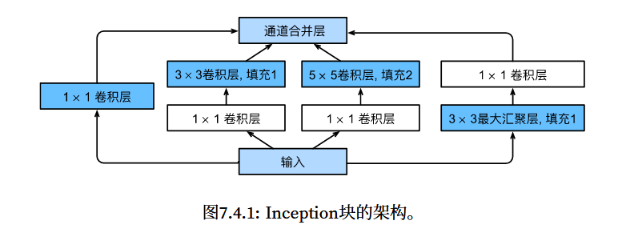       

In [40]:
class Inception(nn.Module):  
    # c1--c4是每条路径的输出通道数  
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):  
        super(Inception, self).__init__(**kwargs) 
        # 线路1,单1x1卷积层  
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1) 
        # 线路2,1x1卷积层后接3x3卷积层  
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)  
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1) 
        # 线路3,1x1卷积层后接5x5卷积层  
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)  
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2) 
        # 线路4,3x3最大汇聚层后接1x1卷积层  
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)  
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)  
    def forward(self, x):  
        p1 = F.relu(self.p1_1(x))  
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))  
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))  
        p4 = F.relu(self.p4_2(self.p4_1(x))) 
        # 在通道维度上连结输出  
        return torch.cat((p1, p2, p3, p4), dim=1)

## 二、创建GoogLeNet

1. 第一个模块使用64个通道、7 × 7卷积层。     out_channels=64
- 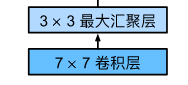

In [91]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),  nn.ReLU(),  
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

2. 第二个模块使用两个卷积层:       out_channels=192
- 第一个卷积层是64个通道、1 × 1卷积层;
- 第二个卷积层使用将通道数量增加三倍的3 × 3卷积层。这对应于Inception块中的第二条路径。      
- 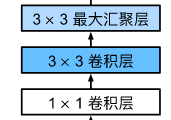

In [95]:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),  nn.ReLU(),  
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),  nn.ReLU(),  
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

3. 第三个模块串联两个完整的Inception块。out_channels=480
- 第一个Inception块的输出通道数为64 + 128 + 32 + 32 = 256,四个路径之间的输出通道数量比为64 : 128 : 32 : 32 = 2 : 4 : 1 : 1。
- > 第二个和第三个路径首先将输入通道的数量分别减少到96/192 = 1/2和16/192 = 1/12,然后连接第二个卷积层。
- 第二个Inception块的输出通道数增加到128 + 192 + 96 + 64 = 480,四个路径之间的输出通道数量比为128 : 192 : 96 : 64 = 4 : 6 : 3 : 2。
- > 第二条和第三条路径首先将输入通道的数量分别减少到128/256 = 1/2和32/256 = 1/8。
- 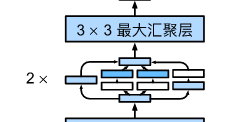

In [98]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),  
                   Inception(256, 128, (128, 192), (32, 96), 64),  
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

4. 第四模块:串联了5个Inception块     out_channels=832
- 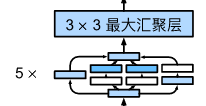

In [102]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64), #out_channels=512
                   Inception(512, 160, (112, 224), (24, 64), 64), #out_channels=512
                   Inception(512, 128, (128, 256), (24, 64), 64), #out_channels=512
                   Inception(512, 112, (144, 288), (32, 64), 64), #out_channels=512
                   Inception(528, 256, (160, 320), (32, 128), 128), #out_channels=832
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

5. 第五模块:串联了2个Inception块,然后紧跟输出层,该模块同NiN一样使用全局平均汇聚层,将每个通道的高和宽变成1。  out_channels=1024   
- 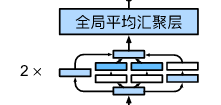

In [105]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),  #out_channels=832
                   Inception(832, 384, (192, 384), (48, 128), 128),  #out_channels=1024
                   nn.AdaptiveAvgPool2d((1,1)),  #1024X1X1
                   nn.Flatten())

In [107]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [109]:
X = torch.rand(size=(1, 1, 96, 96))  
for layer in net:  
    X = layer(X)  
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])
